# Imports

In [972]:
import string

In [973]:
import numpy as np

In [974]:
import pandas as pd

In [975]:
import matplotlib.pyplot as plt
import seaborn as sns

In [976]:
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, ExtraTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer, OneHotEncoder, StandardScaler, MaxAbsScaler, Normalizer, OrdinalEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer

In [977]:
from scipy.stats import randint, uniform

# Functions

In [978]:
def inspect_df(df : pd.DataFrame):
    print(f'Rows:       {df.shape[0]}')
    print(f'Columns:    {df.shape[1]}')
    print("-" * 30)

    null_values = df.isna().sum()
    if (null_values.sum() == 0):
        print('Null values: 0')
    else:
        print('Null values:')
        print(null_values)
    
    print("-" * 30)
    print('Feature data types:')
    print(df.dtypes)
    print("")

In [979]:
def check_balance(df : pd.DataFrame, target_col : str):
    value_counts = (df[target_col].value_counts(normalize=True) * 100).round(2)
    ideal_share = 100 / len(value_counts)
    
    print(f'Value counts for {target_col}:')
    print(value_counts)
    print("-" * 30)
    print(f'The dataset is balanced if the value counts are close to {ideal_share:.2f}%')

In [980]:
def plot_scatter(df : pd.DataFrame, x_feature : str, y_feature : str):
    plt.scatter(df[x_feature], df[y_feature])
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.show()

In [981]:
def evaluate_classifier(model, x_test, y_test, title : str, f1_average : str='binary', f1_pos_label=1):
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average=f1_average, pos_label=f1_pos_label)

    print("")
    print(f"{title.title()}:")
    print(f"Accuracy:                   {accuracy:.4f}")
    print(f"F1 score ({f1_average}):        {f1:.4f}")

    disp = ConfusionMatrixDisplay.from_predictions(
        y_pred, y_test,
        cmap=plt.cm.Blues, 
        normalize='true'    # 'true' normalize on rows
    )
    disp.ax_.set_title(title.title())
    plt.show()

    return y_pred

In [982]:
def evaluate_regressor(model, x_test, y_test, binary=True):
    y_pred = model.predict(x_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    if (y_test > -1).all() & (y_pred > -1).all():
        msle = mean_squared_log_error(y_test, y_pred)
    else:
        msle = "N/A (y_test contiene valori <= -1)"
    r2 = r2_score(y_test, y_pred)

    print("")
    print(f"MAE:    {mae}")
    print(f"MSE:    {mse}")
    print(f"MSLE:   {msle}")
    print(f"R2:     {r2}")
    print("")
    print("Remember: R2 score is in [-inf, 1]. R2<0 --> BAD MODEL.")

    return y_pred

In [983]:
def get_categorical_features(df : pd.DataFrame):
    return df.select_dtypes(include=['object']).columns

In [984]:
def get_k_correlated(df : pd.DataFrame, y_name, k=5):
    y_corr = df.corr()[y_name].abs().sort_values(ascending=False)
    return y_corr[1:(k+1)].index.tolist()

In [985]:
def pfi(model, x_test, y_test):
    pfi = permutation_importance(model, x_test, y_test, n_jobs=-1)
    fig, ax = plt.subplots()
    pd.Series(pfi['importances_mean']).plot.bar(yerr=pfi['importances_std'], ax=ax)
    ax.set_title("Permutation Feature Importance")
    ax.set_ylabel('Importance')
    fig.tight_layout()
    plt.show()

In [986]:
def clean_text(text : str):
    text = text.lower()
    text = text.replace('\n', ' ').replace('\t', ' ').replace('\r', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join(text.split())
    return text

# Exam

In [987]:
backup = pd.read_csv('./dataset.csv', sep=',')
df = backup.copy()
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [988]:
inspect_df(df)

Rows:       32561
Columns:    15
------------------------------
Null values: 0
------------------------------
Feature data types:
age               int64
workclass           str
fnlwgt            int64
education           str
education.num     int64
marital.status      str
occupation          str
relationship        str
race                str
sex                 str
capital.gain      int64
capital.loss      int64
hours.per.week    int64
native.country      str
income              str
dtype: object



In [989]:
check_balance(df, 'income')

Value counts for income:
income
<=50K    75.92
>50K     24.08
Name: proportion, dtype: float64
------------------------------
The dataset is balanced if the value counts are close to 50.00%


In [990]:
degree = df[(df['education'] == 'Bachelors') | (df['education'] == 'Masters') | (df['education'] == 'Doctorate')]
degree.loc[degree['age'] < 40, 'income'].value_counts(normalize=True)

income
<=50K    0.656275
>50K     0.343725
Name: proportion, dtype: float64

In [991]:
df['hours.per.week'] = pd.cut(df['hours.per.week'], bins=[df['hours.per.week'].min(), 30, 50, df['hours.per.week'].max()])
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,"(30, 50]",United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,"(1, 30]",United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,"(30, 50]",United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,"(30, 50]",United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,"(30, 50]",United-States,<=50K


In [992]:
df['income'] = df['income'].map({'<=50K' : 0, '>50K' : 1}).astype('float64')
pivot = ((df.pivot_table(index=['hours.per.week'], columns=['sex'], values=['income'], aggfunc='sum') / df['income'].count()) * 100).round(2)
pivot

income       
sex            Female   Male
hours.per.week              
(1, 30]          0.50   0.57
(30, 50]         2.76  15.61
(50, 99]         0.35   4.27

In [993]:
df['income'] = backup['income']
relation_cr = df.groupby('income')['capital.gain']
print(f'Mean:\n {relation_cr.mean()}')
print(f'Median:\n {relation_cr.median()}')

Mean:
 income
<=50K     148.752468
>50K     4006.142456
Name: capital.gain, dtype: float64
Median:
 income
<=50K    0.0
>50K     0.0
Name: capital.gain, dtype: float64


<Axes: title={'center': 'capital.gain'}, xlabel='income'>

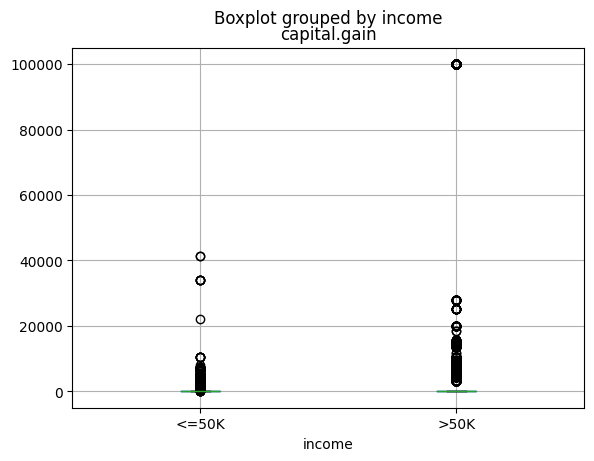

In [994]:
df.boxplot(column='capital.gain', by='income')

In [995]:
df = backup.copy()
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [996]:
df = df.drop_duplicates()
inspect_df(df)

Rows:       32537
Columns:    15
------------------------------
Null values: 0
------------------------------
Feature data types:
age               int64
workclass           str
fnlwgt            int64
education           str
education.num     int64
marital.status      str
occupation          str
relationship        str
race                str
sex                 str
capital.gain      int64
capital.loss      int64
hours.per.week    int64
native.country      str
income              str
dtype: object



In [997]:
df = df.dropna(how='any')
inspect_df(df)

Rows:       32537
Columns:    15
------------------------------
Null values: 0
------------------------------
Feature data types:
age               int64
workclass           str
fnlwgt            int64
education           str
education.num     int64
marital.status      str
occupation          str
relationship        str
race                str
sex                 str
capital.gain      int64
capital.loss      int64
hours.per.week    int64
native.country      str
income              str
dtype: object



In [998]:
cat_features = get_categorical_features(df)
df[cat_features] = OrdinalEncoder().fit_transform(df[cat_features])
df.head()

/tmp/ipykernel_12609/3351726568.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  return df.select_dtypes(include=['object']).columns


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,0.0,77053,11.0,9,6.0,0.0,1.0,4.0,0.0,0,4356,40,39.0,0.0
1,82,4.0,132870,11.0,9,6.0,4.0,1.0,4.0,0.0,0,4356,18,39.0,0.0
2,66,0.0,186061,15.0,10,6.0,0.0,4.0,2.0,0.0,0,4356,40,39.0,0.0
3,54,4.0,140359,5.0,4,0.0,7.0,4.0,4.0,0.0,0,3900,40,39.0,0.0
4,41,4.0,264663,15.0,10,5.0,10.0,3.0,4.0,0.0,0,3900,40,39.0,0.0


In [999]:
X, y = df.drop(columns='income'), df['income']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25)


Extra Tree:
Accuracy:                   0.7972
F1 score (binary):        0.5865


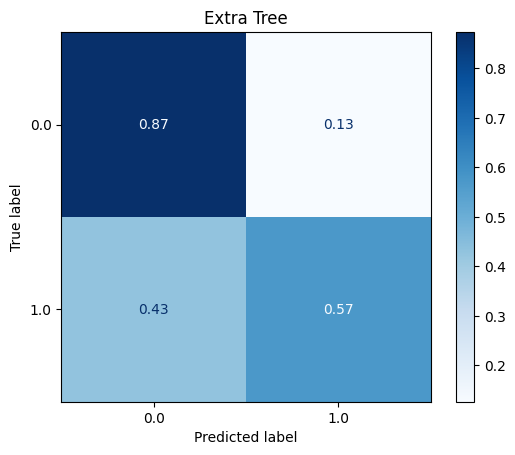


K Neighbors:
Accuracy:                   0.7763
F1 score (weighted):        0.7535


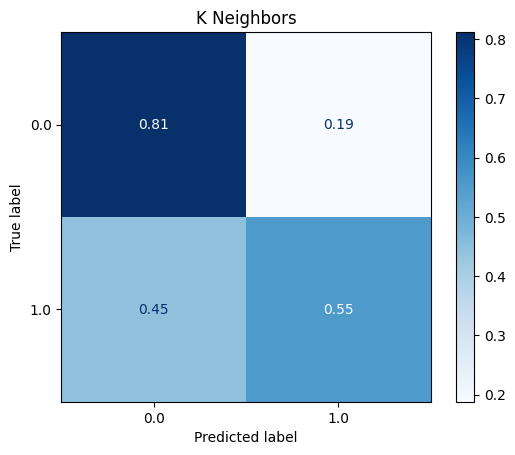


Dummy:
Accuracy:                   0.7614
F1 score (binary):        0.0000


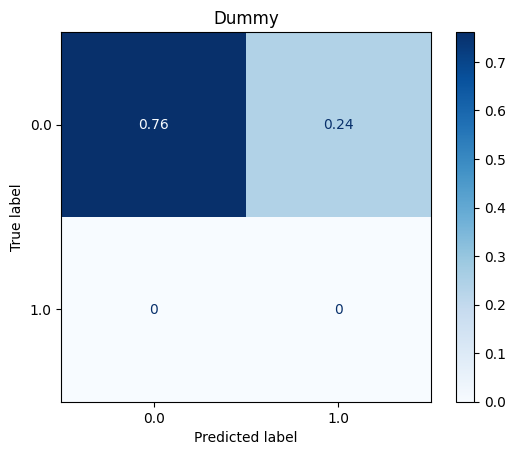

array([0., 0., 0., ..., 0., 0., 0.], shape=(8135,))

In [1000]:
xt = ExtraTreeClassifier()
xt.fit(x_train, y_train)
evaluate_classifier(xt, x_test, y_test, 'extra tree')

kn = KNeighborsClassifier()
kn.fit(x_train, y_train)
evaluate_classifier(kn, x_test, y_test, 'k neighbors', f1_average='weighted')

dc = DummyClassifier()
dc.fit(x_train, y_train)
evaluate_classifier(dc, x_test, y_test, 'dummy')

In [1001]:
mask = (x_test['sex'] == 1.0)
men = (xt.predict(x_test[mask])).sum()
women = (xt.predict(x_test[~mask])).sum()
print(f'Men:    {men}')
print(f'Women:  {women}')

Men:    1726.0
Women:  323.0



Extra Tree - No Sex:
Accuracy:                   0.7998
F1 score (binary):        0.5941


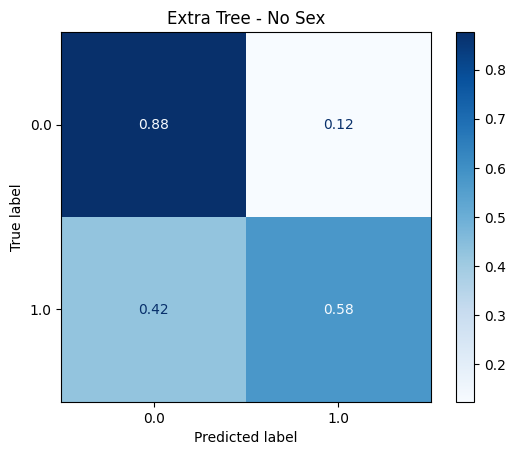

array([0., 0., 0., ..., 0., 0., 1.], shape=(8135,))

In [1002]:
xt = ExtraTreeClassifier()
xt.fit(x_train.drop(columns='sex'), y_train)
evaluate_classifier(xt, x_test.drop(columns='sex'), y_test, 'Extra tree - no sex')


Optimum Extra Trees:
Accuracy:                   0.8089
F1 score (binary):        0.5928


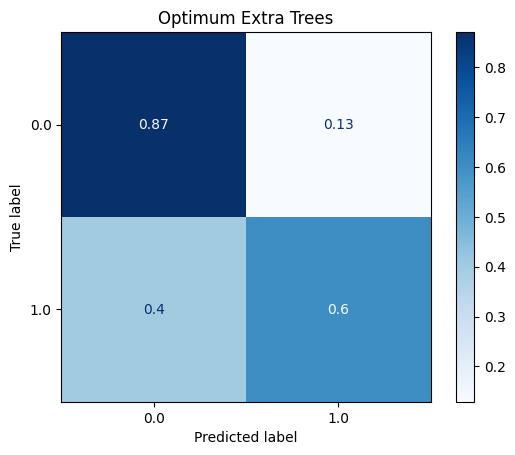

array([0., 0., 0., ..., 0., 1., 0.], shape=(8135,))

In [1003]:
parameters = {
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_depth' : [30, 40, 50, 60, 70, 80, 90]
}

gscv = GridSearchCV(ExtraTreeClassifier(), parameters, cv=10, n_jobs=-1)
gscv.fit(x_train, y_train)
evaluate_classifier(gscv, x_test, y_test, 'optimum extra trees')


Pipeline 1:
Accuracy:                   0.8076
F1 score (binary):        0.5996


/home/mattia/miniconda3/envs/big-data/lib/python3.14/site-packages/sklearn/preprocessing/_discretization.py:304: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
/home/mattia/miniconda3/envs/big-data/lib/python3.14/site-packages/sklearn/preprocessing/_discretization.py:396: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(


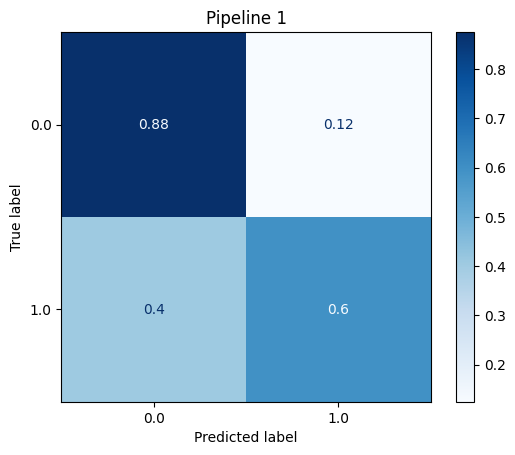

array([1., 0., 0., ..., 0., 1., 0.], shape=(8135,))

In [1004]:
preprocessor = ColumnTransformer(transformers=[
    ('binning', KBinsDiscretizer(), ['age', 'hours.per.week']),
    ('normalize', MinMaxScaler(), ['capital.gain', 'capital.loss'])
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', ExtraTreeClassifier(criterion=gscv.best_params_['criterion'], max_depth=gscv.best_params_['max_depth']))
])

pipeline.fit(x_train, y_train)
evaluate_classifier(pipeline, x_test, y_test, 'pipeline 1')

In [1005]:
df = backup
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [1006]:
X, y = df.drop(columns='income'), df['income']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25)


Pipeline 2:
Accuracy:                   0.7974
F1 score (binary):        0.5828


/tmp/ipykernel_12609/3351726568.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  return df.select_dtypes(include=['object']).columns


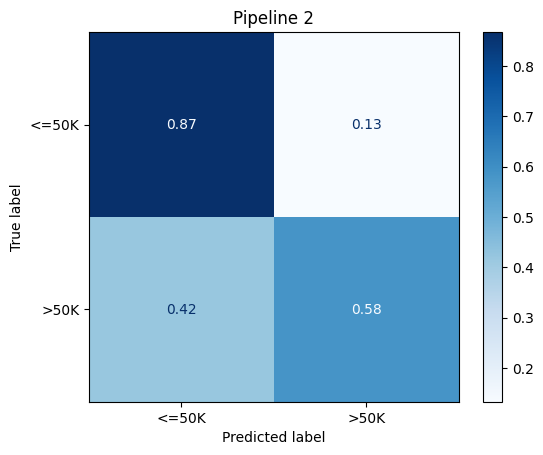

array(['<=50K', '<=50K', '<=50K', ..., '<=50K', '<=50K', '<=50K'],
      shape=(8141,), dtype=object)

In [1007]:
text_cols = get_categorical_features(X)

preprocessor = ColumnTransformer(transformers=[
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), text_cols)
], remainder=StandardScaler())

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', ExtraTreeClassifier())
])

pipeline.fit(x_train, y_train)
evaluate_classifier(pipeline, x_test, y_test, 'pipeline 2', f1_pos_label='>50K')

/tmp/ipykernel_12609/3351726568.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  return df.select_dtypes(include=['object']).columns



Pipeline 3:
Accuracy:                   0.8205
F1 score (binary):        0.5985


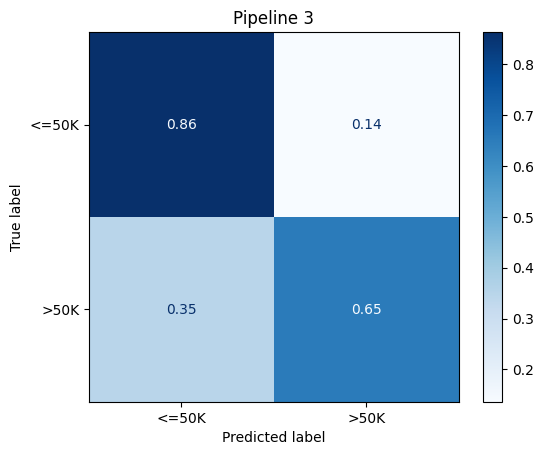

array(['<=50K', '>50K', '<=50K', ..., '<=50K', '>50K', '<=50K'],
      shape=(8141,), dtype=object)

In [1008]:
text_cols = get_categorical_features(X)

preprocessor = ColumnTransformer(transformers=[
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), text_cols)
], remainder=StandardScaler())

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selector', SelectKBest()),
    ('model', ExtraTreeClassifier())
])

parameters = {
    'feature_selector__k' : [5, 7, 10, 12, 14],
    'model__criterion' : ['gini', 'entropy', 'log_loss'],
    'model__max_depth' : [30, 40, 50, 60, 70, 80, 90]
}
gscv = GridSearchCV(pipeline, parameters, cv=10, n_jobs=-1)
gscv.fit(x_train, y_train)
evaluate_classifier(gscv, x_test, y_test, 'pipeline 3', f1_pos_label='>50K')